# Elastic net outshining the lasso

## Libraries importation

First of all, we import all the libraries that we need to use during the mini-project.
* numpy: using mathematical tools on matrix
* seaborn: beautifying graphs for better understanding
* matplotlib.pyplot: ploting graphs to represent data
* Lasso, ElasticNet, LassoCV, ElasticNetCV from sklearn.linear_model: linear models for regression and cross validation
* SelectFromModel from sklearn.feature_selection: tool for variable selection
* MinMaxScaler from sklearn.preprocessing: data scaler

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

## Dataset design

The goal here is to be able to produce several slightly different datasets that will be used to test the stability in features selection of lasso and elastic net models. These datasets must also have their features correlated and scaled. In a matter of generalization, it is interesting to randomize the generation of the samples while keeping the features correlated. In the same direction, the choice of the number of features and the noise level should be available. 

In [2]:
class CustomEvent:
    def __init__(self, n_features=10, noise_level=1, interval=100, negative_corr=True):
        self.n_features = n_features
        self.noise_level = noise_level
        self.interval = interval
        self.negative_corr = negative_corr

    def sample(self, n_samples=1000):
        X = np.zeros((n_samples, self.n_features))
        y = np.random.normal(0, self.noise_level, n_samples)
        base_features = [np.random.uniform(-self.interval,self.interval, n_samples) for _ in range(self.n_features//3+1)]
        for i in range(self.n_features):
            sign = -1 if i%2!=0 and self.negative_corr else 1
            X[:, i] = sign * base_features[i//3] + np.random.normal(0, self.noise_level, n_samples)
        min_max_scaler = MinMaxScaler() 
        X = min_max_scaler.fit_transform(X)
        for i in range(len(base_features)):
            y += (1/10**i) * base_features[i]
        return X, y

The easiest way to check if our samples are correlated is to plot a heatmap of the correlation matrix. So that, we first intialize our event, generate a sample from it, compute the associated correlation matrix and plot it with an heatmap. As expected, the features are highly correlated.

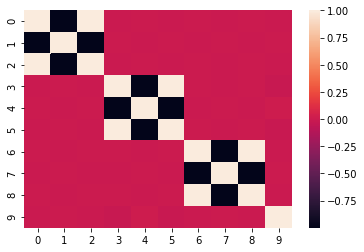

In [3]:
event = CustomEvent()
X, y = event.sample(n_samples=10000)
sns.heatmap(np.corrcoef(X.T))
plt.show()

## Hyperparamaters selection

Before comparing the stability of these 2 regressions, we first have to find the best hyperparameters of each models in order to perform both regressions in optimal conditions. Then it is possible to compare their stability in the features selection. Cross validation is adapted to compute the best parameters. We begin with the lasso model for which we only need to compute the alpha hyperparameter. This paramater is important since it enables the lasso model to select features by forcing variables coefficients to zero thanks to the absolute value used in the penalty formula.

In [4]:
lasso = LassoCV(random_state=0, max_iter=10000)
lasso.fit(X, y)
lasso_alpha = lasso.alpha_
lasso_alpha

0.01641490989094977

It is slighly different for the elastic net model because 2 hyperparamaters need to be computed. First one is alpha which is similar to lasso's alpha since it also influences the penalty. However, here, the penalty is computed in an other way where the l1 ratio takes action. These 2 hyperparameters enable elastic net to be a compromise between ridge and lasso in term of robustness and feature selection.

In [5]:
elastic_net = ElasticNetCV(random_state=0, max_iter=10000)
elastic_net.fit(X, y)
elastic_net_alpha, elastic_net_l1_ratio = elastic_net.alpha_, elastic_net.l1_ratio_
elastic_net_alpha, elastic_net_l1_ratio

(0.03282981978189955, 0.5)

## Stability comparison

We arrive to the problem's heart which is the comparison of stability between lasso and elastic net models when using a dataset with correlated features. To test the stability in features selection for each model, we decide to perform the features selection several times and then count the occurrence of each features subsets. The model has a stable feature selection if, each time, with a slighlty different dataset, it selects the same features subset. Thus, we extract several samples from our event. For each sample, a feature selection is performed using the previously computed hyperparameters. In order to well visualize the distribution of the selected features subsets, we use a barplot that counts occurences of these features subsets.

We begin with the lasso model. According to the statement and the intuitive arguments studied during lectures, we expect to obtain a non-stable features selection.

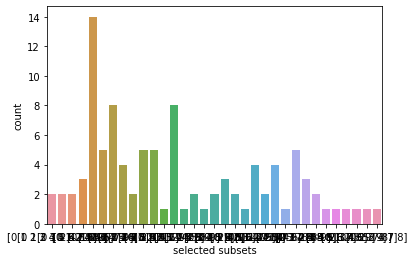

In [6]:
n_times = 100
lasso_selected_feature = []
for _ in range(n_times):
    X, y = event.sample(n_samples=1000)
    lasso_feature_selec = SelectFromModel(estimator=Lasso(alpha=lasso_alpha, max_iter=10000))
    lasso_feature_selec.fit(X, y)
    selected_feature = np.where(lasso_feature_selec.get_support())
    lasso_selected_feature.append(f"{selected_feature[0]}")
sns.countplot(x=lasso_selected_feature)
plt.xlabel('selected subsets')
plt.show()

As expected, the lasso is not stable in his features selection since it oscillates between distinct subsets.

For elastic net, according to the thoritical results of the lecture, we expect it to be stable in terms of the features selection (or at least more stable than the lasso model).

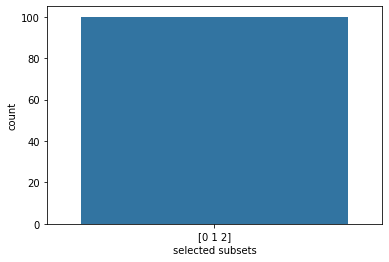

In [7]:
elastic_net_selected_feature = []
for _ in range(n_times):
    X, y = event.sample(n_samples=1000)
    elastic_net_feature_selec = SelectFromModel(estimator=ElasticNet(alpha=elastic_net_alpha, l1_ratio=elastic_net_l1_ratio, max_iter=10000))
    elastic_net_feature_selec.fit(X, y)
    selected_feature = np.where(elastic_net_feature_selec.get_support())
    elastic_net_selected_feature.append(f"{selected_feature[0]}")
sns.countplot(x=elastic_net_selected_feature)
plt.xlabel('selected subsets')
plt.show()

Indeed, elastic net is here very stable since it always select the same variable subset. Thus, we experimentally demonstrated that the elastic net model is more stable than the lasso model when using a dataset with correlated and scaled features. 

## Conclusion

As seen theoritically in the lecture, lasso is unstable if the variables of the input set are highly correlated. Indeed, in a 2D features space, lasso solution lies on an edge of a square, representing the unstability of the solution. We have shown previously that, when slighly changing the dataset, the subsets selected vary a lot.  The l1 parameter introduced in elastic net allows to balance between elastic net and ridge. It enables to select variables, as lasso does, but confers a stability by "removing" the edges. It is therefore stable even if variables are highly correlated, as the selected subset remain the same. 